In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import trimesh
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path


References: Keras Tutorial Version, https://keras.io/examples/vision/pointnet/

In [2]:
prj_path = Path().absolute().parent
data_path = prj_path.parent / "data" / "modelnet" / "ModelNet10"

In [32]:
mesh = trimesh.load( str(data_path / "chair/train/chair_0001.off") )
mesh.show()

## Concepts that should know

### Point Cloud

(2048, 3)


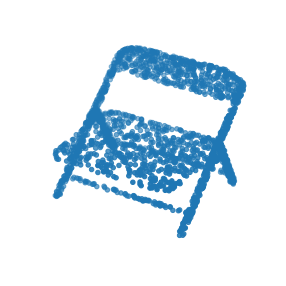

In [31]:
points = mesh.sample(2048)
print(points.shape)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [58]:
# normalisation
points_mean = np.mean(points, axis=0)
points_sub = points - points_mean[np.newaxis, :]
dist = np.max(np.sqrt(np.sum(points_sub**2, axis=1)), 0)
points_normed = points_sub / dist

### Geometric Transformation

Point Clouds are invariant to geometric transformations, i.e. rotation, translation, affine transformations, etc.

Ref: 
* [Geometric Transformation with numpy](https://stackabuse.com/affine-image-transformations-in-python-with-numpy-pillow-and-opencv/)
* [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025)

In [90]:
def draw_points(points, points2=None):
    size = 5
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    if points2 is not None:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=size)
        ax.scatter(points2[:, 0], points2[:, 1], points2[:, 2], c="r", s=size, alpha=0.3)
    else:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=size)
    ax.set_axis_off()
    plt.show()

$$\begin{bmatrix} 
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}$$

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


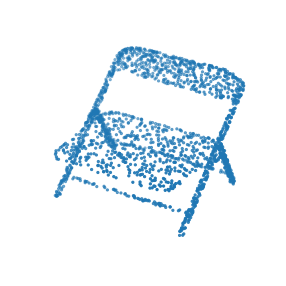

In [91]:
ps = points_normed
# Identity
trans_matrix = np.eye(3)

trans_iden = ps @ trans_matrix
print(trans_matrix)

draw_points(trans_iden)

$$\begin{bmatrix} 
c_x & 0 & 0 \\
0 & c_y & 0 \\
0 & 0 & 1
\end{bmatrix}$$

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]


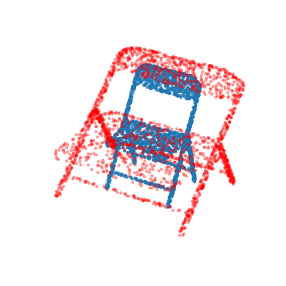

In [92]:
# Scaling
c_x = 2
c_y = 2
trans_matrix = np.eye(3)
trans_matrix[0, 0] *= c_x
trans_matrix[1, 1] *= c_y

trans_scale = ps @ trans_matrix
print(trans_matrix)

draw_points(trans_iden, trans_scale)

$$\begin{bmatrix} 
\cos\theta & \sin\theta & 0 \\
-\sin\theta & \cos\theta & 0 \\
0 & 0 & 1
\end{bmatrix}$$

[[ 0.52532199  0.85090352  0.        ]
 [-0.85090352  0.52532199  0.        ]
 [ 0.          0.          1.        ]]


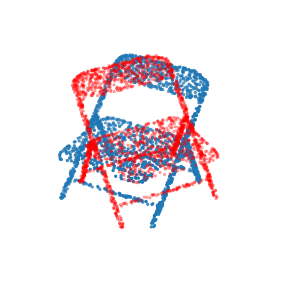

In [93]:
# Rotation
degree = 45
trans_matrix = np.array([
    [ np.cos(degree), np.sin(degree), 0],
    [-np.sin(degree), np.cos(degree), 0],
    [              0,              0, 1]
])

trans_rotate = ps @ trans_matrix
print(trans_matrix)

draw_points(trans_iden, trans_rotate)

[[-0.44807362 -0.89399666  0.        ]
 [ 0.89399666 -0.44807362  0.        ]
 [ 0.          0.          1.        ]]


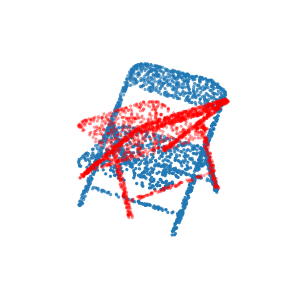

In [94]:
degree = -90
trans_matrix = np.array([
    [ np.cos(degree), np.sin(degree), 0],
    [-np.sin(degree), np.cos(degree), 0],
    [              0,              0, 1]
])

trans_rotate = ps @ trans_matrix
print(trans_matrix)

draw_points(trans_iden, trans_rotate)

$$\begin{bmatrix} 
1 & 0 & t_x \\
0 & 1 & t_y \\
0 & 0 & 1
\end{bmatrix}$$

[[ 1.    0.   -0.75]
 [ 0.    1.   -0.75]
 [ 0.    0.    1.  ]]


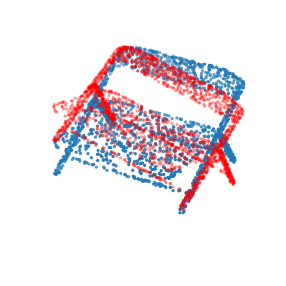

In [98]:
# Translation
t_x = -0.75
t_y = -0.75
trans_matrix = np.eye(3)
trans_matrix[0, 2] += t_x
trans_matrix[1, 2] += t_y

trans_trans = ps @ trans_matrix
print(trans_matrix)

draw_points(trans_iden, trans_trans)

$$\begin{bmatrix} 
1 & s_h & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}$$

[[1.  1.5 0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]]


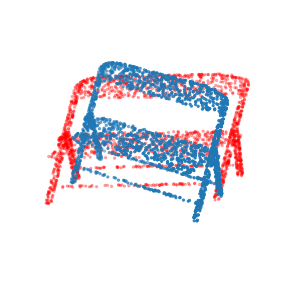

In [100]:
# Horizontal Shear
s_h = 1.5
trans_matrix = np.eye(3)
trans_matrix[0, 1] += s_h

trans_hs = ps @ trans_matrix
print(trans_matrix)

draw_points(trans_iden, trans_hs)

$$\begin{bmatrix} 
1 & 0 & 0 \\
s_v & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}$$

[[1.  0.  0. ]
 [1.5 1.  0. ]
 [0.  0.  1. ]]


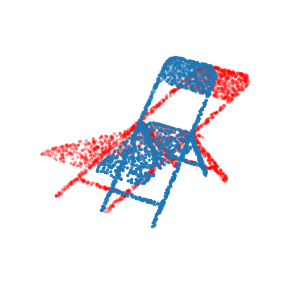

In [101]:
# Vertical Shear
s_v = 1.5
trans_matrix = np.eye(3)
trans_matrix[1, 0] += s_v

trans_vs = ps @ trans_matrix
print(trans_matrix)

draw_points(trans_iden, trans_vs)

## Create Dataset

In [ ]:
# TBD

## Model

<img src="https://drive.google.com/uc?id=1ZZbw0itgC1p1wMHW-ZLEYM03PP9wz-pU" alt="pointnet-model" width="720" height="360">


In [13]:
points_tensor = torch.FloatTensor(points).T.unsqueeze(0)
print(points_tensor.size())

torch.Size([1, 3, 2048])


### Transform

In [20]:
class TNetConvModule(nn.Module):
    """Transform Network Convolution Module"""
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.bn = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        return torch.relu(self.bn(self.conv(x)))
    
    
class TNetFcModule(nn.Module):
    """Transform Network Fully Connected Module"""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        
    def forward(self, x):
        return torch.relu(self.bn(self.linear(x)))
    
    
class TransformNet(nn.Module):
    """Mini PointNet: T-Net"""
    def __init__(self, k):
        r"""
        Args:
            - k: transformation size
        """
        super().__init__()
        self.k = k 
        self.conv1 = TNetConvModule(self.k, 64, 1)
        self.conv2 = TNetConvModule(64, 128, 1)
        self.conv3 = TNetConvModule(128, 1024, 1)
        self.fc1 = TNetFcModule(1024, 512)
        self.fc2 = TNetFcModule(512, 256)
        self.geotrans = nn.Linear(256, self.k*self.k) # geometric transformation invariance
        
    def forward(self, x):
        r"""
        B: Batch size
        C: Input Channel size
        N: Number of points
        -------------------------
        Inputs:
            - x: point cloud (B, C, N)
        """
        x = self.conv1(x)  # (B, C, N) --> (B, 64, N)  
        x = self.conv2(x)  # (B, 64, N) --> (B, 128, N)
        x = self.conv3(x)  # (B, 128, N) --> (B, 1024, N)
        x = torch.max(x, 2, keepdim=True)[0].squeeze(-1)  # (B, 1024, N) --> (B, 1024)  
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        
    

### Symmetry Function